# Importing Libraries and Loading Data

In [1]:
import pandas as pd
import numpy as np

import re
import nltk
from nltk.corpus import stopwords

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm

from sklearn import metrics
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 

from sklearn.pipeline import Pipeline

import pickle

#
from supervised.automl import AutoML

Import data

In [2]:
df_fakenews = pd.read_csv(r'data\fakeNews.csv')[['Text', 'Binary Label']]
df_truenews = pd.read_csv(r'data\trueNews.csv')[['Text', 'Label']]

Data preparation

In [3]:
df_fakenews.columns = ['Text', 'Label']
data = df_fakenews.append(df_truenews).reset_index(drop = True)

In [4]:
data

,Text,Label
0,Tencent revealed the real number of deaths.\t\t,0
1,Taking chlorine dioxide helps fight coronavir...,0
2,This video shows workmen uncovering a bat-inf...,0
3,The Asterix comic books and The Simpsons pred...,0
4,Chinese President Xi Jinping visited a mosque...,0
...,...,...
7583,Global COVID-19 prevention trial of hydroxychl...,1
7584,Bavaria's free COVID-19 test for all splits Ge...,1
7585,Britain locks down city of Leicester after COV...,1
7586,UK imposes lockdown on city of Leicester to cu...,1


# Data Exploration and Data Engineering

In [5]:
data['Label'].value_counts()

0    3795
1    3793
Name: Label, dtype: int64

### Filling Missing Values

In [8]:
data.isnull().sum()

Text     0
Label    0
dtype: int64

In [9]:
data=data.fillna(' ')
print(data.isnull().sum())

Text     0
Label    0
dtype: int64


### Removing punctuations and converting data to lowercase

In [10]:
data['Text'] = data['Text'].str.replace('[^\w\s]','')
data['Text'] = data['Text'].str.lower()

The default value of regex will change from True to False in a future version.


In [11]:
data['Text'][0]

' tencent revealed the real number of deaths\t\t'

In [12]:
data['Text'][45]

' coronavirus cases reported in rome georgia\t\t'

### Word Cloud Visualization

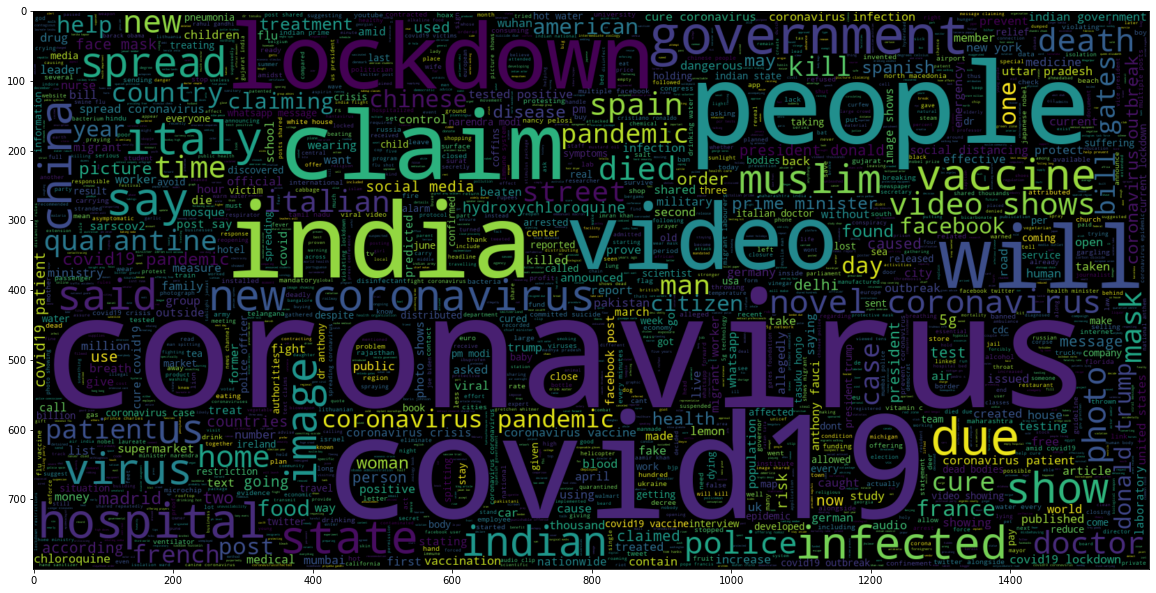

In [13]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(data[data.Label == 0].Text))
plt.imshow(wc, interpolation = 'bilinear')

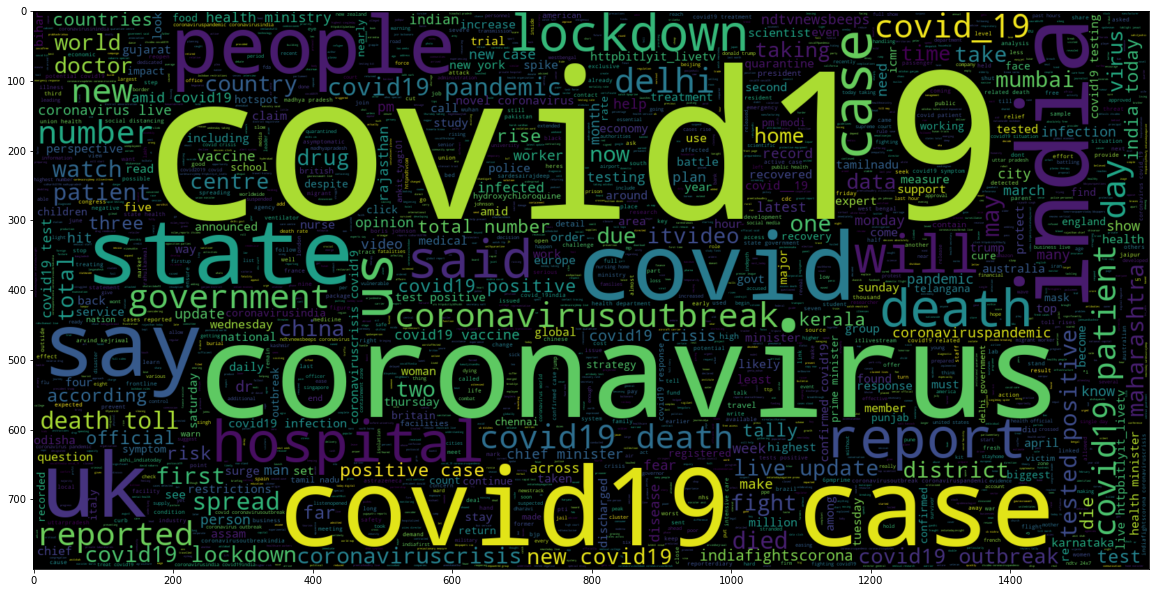

In [14]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(data[data.Label == 1].Text))
plt.imshow(wc, interpolation = 'bilinear')

## Train-Test Split

In [15]:
y = data.Label
y

0       0
1       0
2       0
3       0
4       0
       ..
7583    1
7584    1
7585    1
7586    1
7587    1
Name: Label, Length: 7588, dtype: int64

In [16]:
data.drop("Label", axis=1,inplace=True)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(data['Text'], y, test_size=0.2,random_state=102)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(6070,) (6070,)
(1518,) (1518,)


### Cleaning Data using NLP Techniques

In [18]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.80)  
tfidf_train = tfidf_vectorizer.fit_transform(X_train) 
tfidf_test = tfidf_vectorizer.transform(X_test)

# Implementing Classification Algorithm

### autoML

In [19]:
automl = AutoML(mode="Explain"
                    , explain_level = 2
                    , train_ensemble=False                          
)

In [22]:
tfidf_train = tfidf_train.toarray() 

In [23]:
automl.fit(tfidf_train, y_train)

Linear algorithm was disabled.
AutoML directory: AutoML_1
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML steps: ['simple_algorithms', 'default_algorithms']
* Step simple_algorithms will try to check up to 2 models
1_Baseline logloss 0.693105 trained in 30.92 seconds


Disable SHAP explanations because of number of columns > 500.


2_DecisionTree logloss 0.341072 trained in 527.59 seconds
Skip default_algorithms because of the time limit.
AutoML fit time: 3994.26 seconds
AutoML best model: 2_DecisionTree


AutoML(explain_level=2, train_ensemble=False)

In [25]:
pred3 = automl.predict(tfidf_test.toarray() )

print('Accuracy of SVM on test set:',accuracy_score(y_test, pred3))

Accuracy of SVM on test set: 0.839262187088274


In [26]:
results3=confusion_matrix(y_test, pred3)
print(results3)

[[576 212]
 [ 32 698]]


# Pipeline Creation

In [27]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.80)),
    ('clf',svm.SVC(kernel='linear'))])

In [28]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.8, stop_words='english')),
                ('clf', SVC(kernel='linear'))])

In [29]:
result=pipeline.predict(["One of the challenges being faced worldwide is the rate of infection of health professionals while treating COVID-19 patients.  2016 statistics show the following picture of Rwanda’s health sector: 1/50,505 ground ambulance / population Ratio; 1/10,055 Doctor/population ratio; 1/1,094 Nurse/population ratio; 1/10,500 Laboratory technicians /population ratio. Although Rwanda is on track to meeting most of the required quota, the country cannot afford the set back that a pandemic like COVID-19 among health professionals would cause. To minimize contact time with confirmed cases and therefore reducing the risk of contamination of health professionals in COVID-19 treatment centres, robots were deployed. At Gatenga and Kanyinya treatment centres in Kigali City, visits by medical staff to patients went from 3-4 to 2 per day since May 2020. The 5 human-size robots are programmed to perform temperature screening, take readings of vitals, deliver video messages and detect people not wearing masks then instruct them to wear masks properly. On Tuesday, May 19 at the Kanyinya COVID-19 Treatment Centre, the 5 robots were launched by the Ministry of Health. Named in Kinyarwanda, Akazuba, Ikirezi, Mwiza, Ngabo, and Urumuri are made by Zora Bots, a Belgian company specialised in robotics. They were acquired through a partnership between the UNDP Rwanda Accelerator Lab (AccLab) and the Ministry of ICT and Innovation.  Each robot costs about $30,000. Urumuri is currently deployed at the Kigali International Airport with the capacity to screen 50 to 150 people per minute and report abnormalities to officers on duty. As Rwanda is reopening Kigali International Airport for commercial international flights from 1st of August, Urumuri will allow to speed up mass screenings of fever for passengers as they land. Smart anti-epidemic robots have been used in Asia to help flatten the COVID-19 curve. The pandemic has proven to be a crosscutting challenge affecting Rwanda in all sectors (Health, Economy, Education, Agriculture, …). It therefore requires different sometimes innovative solutions with available resources like robots."])
print(result)

[1]


In [30]:
result=pipeline.predict(["Bulgaria has e death rate of 0.1%"])
print(result)

[0]


In [32]:
Pkl_Filename = "automl_model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(pipeline, file)

In [35]:
import os
os.getcwd()

'C:\\Users\\ivan.mitkov\\Documents\\Fake-News-Detection'